In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential

# Damped Harmonic Oscillator

The damped harmonic oscillator equation is given by:

$$ \ddot{x} + \mu\dot{x} + \omega_0^2x = 0 $$

with initial conditions:

$$ x(0) = x_0, \quad \dot{x}(0) = v_0 $$


In [ ]:
def dho(t, x0, v0, mu=0.1, w0=2) -> np.ndarray:

  gamma = mu / 2
  omega = np.sqrt(w0**2 + gamma**2)
  phi = np.arctan(-(v0 + gamma * x0) / (x0 * omega))
  A = x0 / np.cos(phi)

  return A * tf.math.exp(-gamma * t) * tf.math.cos(omega * t + phi)

# Nondimentionalization
The damped harmonic oscillator system above can be converted into nondimensionalized system by scaling the variables $x$ and $t$:

$$\tilde{x} = \frac{x}{x_s}, \quad \tilde{t} = \frac{t}{t_s}$$

Subtituting into the damped harmonic oscillator equation gives:

$$ \ddot{\tilde{x}} + \frac{\mu t_s}{m}\dot{\tilde{x}} + \frac{k t_s^2}{m}\tilde{x} = 0 $$

Choosing the initial conditions such that:

$$ \tilde{x}(0) = \frac{x_0}{x_s}= 1, \quad \dot{\tilde{x}}(0) = \frac{t_sv_0}{x_s} = 1 $$

gives the following nondimensionalized initial value problem:

$$ \ddot{\tilde{x}} + \alpha\dot{\tilde{x}} + \beta\tilde{x} = 0, \quad \tilde{x}(0) = 1, \quad \dot{\tilde{x}}(0) = 1 $$

where:

$$\begin{align}
\alpha &= \frac{\mu x_0}{mv_0}, \quad \beta = \frac{k x_0^2}{m v_0^2} \\
\tilde{x} &= \frac{x}{x_0}, \qquad \tilde{t} = \frac{v_0 t}{x_0}
\end{align}$$



Random fourier features to acount for low frequency bias.

x_data = x_data / x_data[0]

t_data = t_data * v0 / x_data[0]


In [ ]:
def nondimensionalize_dho(x, t, v0=1):
  x = x / x[0]
  t = (t * v0) / x[0]  #this is because v_0 is 1
  return x, t

(500, 1) (500, 1)
(10, 1) (10, 1)


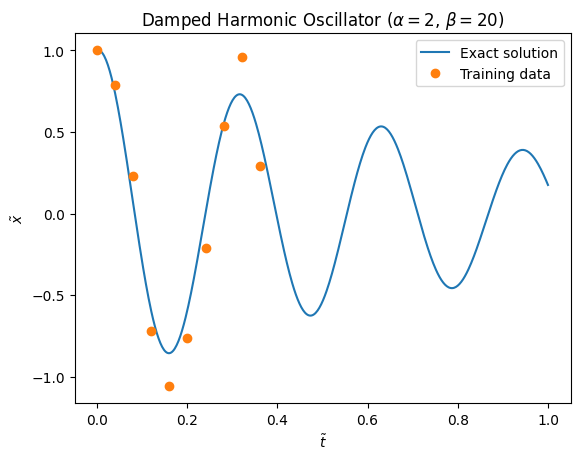

In [ ]:
alpha, beta = 2, 20

# get the analytical solution over the full domain
t_data = tf.cast(tf.reshape(tf.linspace(0, 1, 500), shape=(-1, 1)), tf.float32)
x_data = dho(t_data, x0=1, v0=1, mu=alpha, w0=beta)
print(t_data.shape, x_data.shape)

# slice out a small number of points from the LHS of the domain
t_train = t_data[0:200:20]
x_train = x_data[0:200:20] + tf.random.normal(shape=(10, 1), stddev=np.sqrt(0.05))
print(t_train.shape, x_train.shape)

x_train, t_train = nondimensionalize_dho(x_train, t_train)

t_physics = tf.cast(tf.reshape(tf.linspace(0, 1, 30), shape=(-1, 1)), tf.float32)

plt.figure()
plt.title("Damped Harmonic Oscillator ($\u03b1 = 2$, $\u03b2 = 20$)")
plt.plot(t_data, x_data, label="Exact solution")
plt.plot(t_train, x_train, "o", label="Training data")
#plt.scatter(t_physics, np.zeros(30), color="tab:blue", label="Domain")
plt.xlabel("$\~t$")
plt.ylabel("$\~x$")
plt.legend()
plt.show()

In [ ]:
t_data[:10]

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[0.        ],
       [0.00200401],
       [0.00400802],
       [0.00601202],
       [0.00801603],
       [0.01002004],
       [0.01202405],
       [0.01402806],
       [0.01603206],
       [0.01803607]], dtype=float32)>

The loss function is given as follows:

$$ \mathcal{L} = \frac{1}{N}\sum_{i=1}^{N}(x_i - \hat{x}_i)^2 + \frac{1}{M}\sum_{i=1}^{M}(\ddot{x}(t_i) + \mu\dot{x}(t_i) + \omega_0^2x(t_i))^2 + (x(0) - 1)^2 + (\dot{x}(0) - 1)^2$$

This loss has two trainable parameters $\mu$ and $\omega_0$ which are learned by training the model on a particular harmonic oscillator.

# Mathematical Formulation for Echo-state mapping

Let $\mathbf{x}(n) \in \mathbb{R}^d$ denote the input at time step $n$, $\mathbf{y}(n) \in \mathbb{R}^m$ denote the output at time step $n$, and $\mathbf{h}(n) \in \mathbb{R}^n$ denote the internal state of the network at time step $n$. The dynamics of an ESN can be described by the following equations:

\begin{align}
\mathbf{h}(n) &= f(\mathbf{W}_{\text{in}} \mathbf{x}(n) + \mathbf{W} \mathbf{h}(n-1)) \\
\end{align}

where $\mathbf{W}_{\text{in}} \in \mathbb{R}^{n \times d}$ is the input-to-hidden weight matrix, $\mathbf{W} \in \mathbb{R}^{n \times n}$ is the reservoir weight matrix, $\mathbf{W}_{\text{out}} \in \mathbb{R}^{m \times n}$ is the hidden-to-output weight matrix, and $f(\cdot)$ is the activation function.

In [ ]:
# class EchoStateReservoir(tf.keras.layers.Layer):
#     def __init__(self, reservoir_units, spectral_radius=0.9, sparsity=0.9, **kwargs):
#         super(EchoStateReservoir, self).__init__(**kwargs)
#         self.reservoir_units = reservoir_units
#         self.spectral_radius = spectral_radius
#         self.sparsity = sparsity

#     def build(self, input_shape):
#         # Initialize reservoir weights shape dynamically
#         reservoir_shape = (self.reservoir_units, self.reservoir_units)
#         self.reservoir_weights = self.add_weight(
#             shape=reservoir_shape,
#             initializer='random_normal',
#             trainable=False
#         )

#         # Initialize input weights shape dynamically
#         input_weights_shape = (self.reservoir_units, input_shape[-1])  # Adjusted for batch dimension
#         self.input_weights = self.add_weight(
#             shape=input_weights_shape,
#             initializer='random_normal',
#             trainable=False
#         )

#         # Initialize state shape dynamically without the batch dimension
#         state_shape = (self.reservoir_units, 1)  # Adjusted for batch dimension
#         self.state = self.add_weight(
#             shape=state_shape,
#             initializer='zeros',
#             trainable=False
#         )

#         # Sparsity mask
#         self.mask = tf.keras.backend.random_binomial(
#             (self.reservoir_units, self.reservoir_units),
#             p=self.sparsity,
#             dtype=tf.float32
#         )

#         # Apply sparsity mask and scale matrix until spectral radius is as expected
#         self.reservoir_weights.assign(
#             self.reservoir_weights * self.mask * self.spectral_radius / tf.reduce_max(tf.abs(tf.linalg.eigvals(self.reservoir_weights)))
#         )

#     def call(self, inputs):
#         # Remove batch dimension and convert input vector to matrix for matmul
#         inputs = tf.squeeze(inputs, axis=0)
#         inputs = tf.expand_dims(inputs, 1)

#         print("Input weight matrix shape : ", self.input_weights.shape)
#         print("Input shape : ", inputs.shape)
#         print("Reservoir matrix shape : ", self.reservoir_weights.shape)
#         print("State vector shape : ", self.state.shape)

#         input_matmul = tf.matmul(self.input_weights, inputs)
#         reservoir_matmul = tf.matmul(self.reservoir_weights, self.state)
#         reservoir_output = tf.tanh(input_matmul + reservoir_matmul)

#         self.state = reservoir_output
#         return reservoir_output


In [ ]:
class EchoStateLayer(tf.keras.layers.SimpleRNN):
    def __init__(self, units, connectivity_prob=0.1, spectral_radius=0.9, **kwargs):
        super(EchoStateLayer, self).__init__(units, **kwargs)
        self.connectivity_prob = connectivity_prob
        self.spectral_radius = spectral_radius

    def build(self, input_shape):
        super(EchoStateLayer, self).build(input_shape)
        input_dim = input_shape[-1]
        self.kernel_mask = tf.random.uniform((input_dim, self.units)) < self.connectivity_prob
        self.recurrent_mask = tf.random.uniform((self.units, self.units)) < self.connectivity_prob

        self.kernel = self.add_weight(shape=(input_dim, self.units),
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)

        self.recurrent_kernel = self.add_weight(shape=(self.units, self.units),
                                                 initializer=self.recurrent_initializer,
                                                 name='recurrent_kernel',
                                                 regularizer=self.recurrent_regularizer,
                                                 constraint=self.recurrent_constraint)

        # Normalize the recurrent weights to ensure spectral radius < 1
        self.normalize_recurrent_weights()

        # Freeze the layer
        self.trainable = False

    def normalize_recurrent_weights(self):
        recurrent_matrix = self.recurrent_kernel.numpy()
        max_eigenvalue = max(abs(tf.linalg.eigvals(recurrent_matrix)))
        scaling_factor = self.spectral_radius / max_eigenvalue
        self.recurrent_kernel.assign(self.recurrent_kernel * scaling_factor)

    def call(self, inputs, states=None):
        return super(EchoStateLayer, self).call(inputs, states)

In [ ]:
class dho_PINN(tf.keras.Sequential):
    def __init__(self, alpha, beta, num_outputs):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.num_outputs = num_outputs

def build_dho_PINN(alpha, beta, input_shape, units, layers):

    model = dho_PINN(alpha, beta, num_outputs=1)
    model.add(Input(shape=(input_shape)))
    #model.add(EchoStateLayer(20))
    for _ in range(layers):
        model.add(Dense(units, activation='tanh'))
    model.add(Dense(1))
    return model



In [ ]:
class dho_loss(tf.keras.losses.Loss):

  def __init__(self, t_physics):

    super(dho_loss, self).__init__()
    self.t_physics = t_physics
    self.t0 = tf.constant(0.0, shape=(1,))
    self.one = tf.constant(1.0, shape=(1,))
    # Lagrange co-efficients
    self.l_data = self.l_physics = self.l_ic = 1.0

  def __call__(self, x_true, x_pred, model):

    data_loss = self.data_loss(x_true, x_pred)
    physics_loss = self.physics_loss(model)
    ic_loss = self.ic_loss(model)
    return data_loss + (1e-4) * physics_loss + (1e-4) * ic_loss

  def data_loss(self, x_true, x_pred):

    squared_errors = tf.square(x_true - x_pred)
    return tf.reduce_mean(squared_errors)

  def physics_loss(self, model):

    with tf.GradientTape() as tape1:
      tape1.watch(self.t_physics)
      with tf.GradientTape() as tape2:
        tape2.watch(self.t_physics)
        x = model(self.t_physics)
      dx_dt = tape2.gradient(x, self.t_physics)
    d2x_dt2 = tape1.gradient(dx_dt, self.t_physics)

    squared_errors = tf.square(d2x_dt2 + model.alpha * dx_dt + (model.beta**2) * x)
    return tf.reduce_mean(squared_errors)


  def ic_loss(self, model):

    with tf.GradientTape() as tape:
        tape.watch(self.t0)
        t0_expanded = tf.expand_dims(self.t0, axis=-1)  # Reshape input tensor to make it 3D
        x0 = model(t0_expanded)
    v0 = tape.gradient(x0, self.t0)

    squared_errors = tf.square(x0 - self.one) + tf.square(v0 - self.one)
    return tf.reduce_sum(squared_errors)


In [ ]:
#@tf.function
def train(t_train, x_train, model, loss_function, epochs):

  loss_history = []
  for epoch in range(1, epochs + 1):

    with tf.GradientTape() as tape:
      x_pred = model(t_train)
      loss = loss_function(x_train, x_pred, model)
      loss_history.append(loss.numpy())

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if epoch % 1000 == 0:
      print(epoch, loss.numpy())

  return loss_history


In [ ]:
print(t_train)

tf.Tensor(
[[0.        ]
 [0.04008016]
 [0.08016032]
 [0.12024048]
 [0.16032064]
 [0.2004008 ]
 [0.24048096]
 [0.28056112]
 [0.32064128]
 [0.36072144]], shape=(10, 1), dtype=float32)


In [ ]:
PINN = build_dho_PINN(alpha, beta, t_train.shape, 32, 3)
PINN.summary()

optimizer = Adam(learning_rate=0.001)

t_physics = np.linspace(0, 1, 30).reshape((-1, 1))
t_physics = tf.constant(t_physics, dtype=tf.float32)
loss_function = dho_loss(t_physics)

Model: "dho_pinn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10, 32)            64        
                                                                 
 dense_1 (Dense)             (None, 10, 32)            1056      
                                                                 
 dense_2 (Dense)             (None, 10, 32)            1056      
                                                                 
 dense_3 (Dense)             (None, 10, 1)             33        
                                                                 
Total params: 2209 (8.63 KB)
Trainable params: 2209 (8.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
PINN_loss = train(t_train, x_train, PINN, loss_function, 10)
plt.plot(PINN_loss[90:])

AttributeError: in user code:

    File "<ipython-input-9-ec154b414af8>", line 10, in train  *
        loss_history.append(loss.numpy())

    AttributeError: 'SymbolicTensor' object has no attribute 'numpy'


In [ ]:
PINN_loss += train(t_train, x_train, PINN, loss_function, 10000)
plt.plot(PINN_loss[90:])

In [ ]:
print(loss_function.l_data, loss_function.l_physics, loss_function.l_ic)

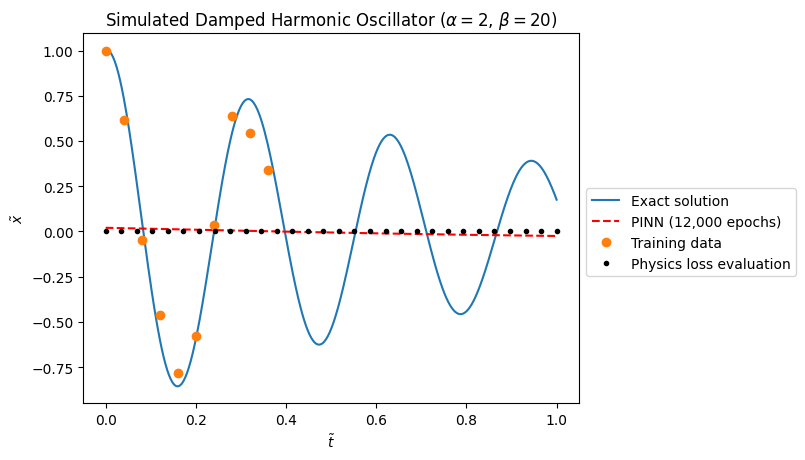

In [ ]:
plt.title("Simulated Damped Harmonic Oscillator ($\u03b1 = 2$, $\u03b2 = 20$)")
plt.plot(t_data, x_data, label="Exact solution")
plt.plot(t_data, PINN(t_data), 'r--', label="PINN (12,000 epochs)")
plt.plot(t_train, x_train, 'o', label="Training data")
plt.plot(t_physics, np.zeros(30), "k.", label="Physics loss evaluation")
plt.xlabel("$\~t$")
plt.ylabel("$\~x$")
plt.legend(bbox_to_anchor=(1, 0.6))

In [ ]:
class dho_discovery_PINN(tf.keras.Sequential):

  def __init__(self):
    super().__init__()
    self.alpha = tf.Variable(initial_value=1.0, trainable=True)
    self.beta = tf.Variable(initial_value=1.0, trainable=True)

def build_dho_discovery_PINN(units, layers):

  model = dho_discovery_PINN()
  model.add(Input(shape=(1,)))
  for _ in range(layers):
    model.add(Dense(units, activation='tanh'))
  model.add(Dense(1))
  return model

In [ ]:
t_train = t_data[0::20]
x_train = x_data[0::20] + tf.random.normal(shape=(25, 1), stddev=0.1)
print(t_train.shape, x_train.shape)

x_train, t_train = nondimensionalize_dho(x_train, t_train)

discovery_PINN = build_dho_discovery_PINN(alpha, beta, 32, 3)
discovery_PINN.summary()

optimizer = Adam(learning_rate=0.001)

t_physics = np.linspace(0, 1, 30).reshape((-1, 1))
t_physics = tf.constant(t_physics, dtype=tf.float32)
loss_function = dho_loss(t_physics)

In [ ]:
discovery_PINN_loss = train(t_train, x_train, discovery_PINN, loss_function, 24000)

In [ ]:
print(discovery_PINN.alpha, discovery_PINN.beta)
plt.plot(discovery_PINN_loss)

In [ ]:
plt.title("Simulated Damped Harmonic Oscillator ($\u03b1 = 2$, $\u03b2 = 20$)")
plt.plot(t_data, x_data, label="Exact solution")
plt.plot(t_data, discovery_PINN(t_data), 'r--', label="PINN (24,000 epochs)")
plt.plot(t_train, x_train, 'o', label="Training data")
plt.xlabel("$\~t$")
plt.ylabel("$\~x$")
plt.legend(bbox_to_anchor=(1, 0.6))